In [3]:
from qiskit import *
from qiskit.visualization import *
from math import pi, sqrt
import numpy as np

In [150]:
def grover_operator(circuit, n, target_binary):
    # Grover's Oracle
    oracle_gate = grover_oracle(n, target_binary)
    circuit.append(oracle_gate, range(n+1))
    
    circuit.h(range(n+1))
    circuit.x(range(1, n+1))
    
    # Amplifier
    amplification_gate = amplification(n)
    circuit.append(amplification_gate, range(1, n+1))

    circuit.x(range(1, n+1))
    circuit.h(range(1, n+1))

In [151]:
def grover_oracle(n, target_binary):
    circuit = QuantumCircuit(n+1)
    
    # Grover's Oracle
    for index, value in reversed(list(enumerate(target_binary))):  
        if value == '0':
            circuit.x(n-index)    
            # Adding X gate to the qubit with |0> value. Also the order of qubits is reversed in Qiskit.

    control_qubits = [1, 2, 3, 4]
    circuit.mct(control_qubits, 0, n)

    for index, value in enumerate(target_binary):  
        if value == '0':
            circuit.x(n-index)  
    
    oracle_gate = circuit.to_gate()
    oracle_gate.name = 'Oracle'
    
    return oracle_gate

In [152]:
def amplification(n):
    circuit = QuantumCircuit(n)
    
    # Amplifier (implemented from q1 to q4)
    # V
    circuit.cu1(pi/4, 3, 0)

    # V-dagger
    circuit.cx(3, 2)    # cx(4, 3) (ancillia is q0)
    circuit.cu1(-pi/4, 2, 0)
    circuit.cx(3, 2)    # cx(4, 3)

    # V
    circuit.cu1(pi/4, 2, 0)

    # V-dagger
    circuit.cx(2, 1)    # cx(3, 2)
    circuit.cu1(-pi/4, 1, 0)

    # V
    circuit.cx(3, 1)    # cx(4, 2)
    circuit.cu1(pi/4, 1, 0)

    # V-dagger
    circuit.cx(2, 1)    # cx(3, 2)
    circuit.cu1(-pi/4, 1, 0)

    # V
    circuit.cx(3, 1)    # cx(4, 2)
    circuit.cu1(pi/4, 1, 0)

    amplification_gate = circuit.to_gate()
    amplification_gate.name = 'Amplification'
    
    return amplification_gate

In [153]:
def initialize(circuit, n):
    # circuit.reset(range(n+1))
    circuit.x(0)
    circuit.barrier()

    circuit.h(range(n+1))
    circuit.barrier()

In [207]:
def get_target(n):
    # Target qubit combination  
#     target = int(input('Enter the target number (from 0 to 15): '))
    max_n = 2**n
    target = np.random.randint(max_n)
    print('Target number: ', target)

    # Target Binary
    target_binary = "{0:04b}".format(target)
    print('Target binary: ', target_binary)
    
    return target, target_binary

In [208]:
def main():
    # Qubits
    n = 4     # n = int(input('Enter number of required qubits: '))
    print('Number of qubits: ', n)
    
    # Target
    target, target_binary = get_target(n)
    
    # Initialize  
    circuit = QuantumCircuit(n+1, n)    # Add one for ancillia qubit
    initialize(circuit, n)  
    
    # Grover's Operator
    grover_operator(circuit, n, target_binary)
#     grover_operator(circuit, n, target_binary)
#     grover_operator(circuit, n, target_binary)
    
    # End
    circuit.barrier()
    circuit.measure(range(1, n+1), range(n))
    
    # circuit.draw('mpl')
    return circuit

Number of qubits:  4
Target number:  11
Target binary:  1011


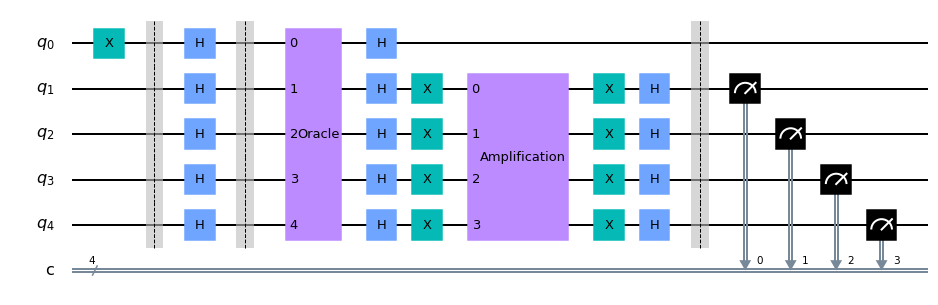

In [209]:
circuit = main()
circuit.draw('mpl')

{'0000': 38, '0001': 41, '0010': 43, '0011': 28, '0100': 46, '0101': 31, '0110': 38, '0111': 46, '1000': 34, '1001': 34, '1010': 36, '1011': 478, '1100': 34, '1101': 28, '1110': 32, '1111': 37}


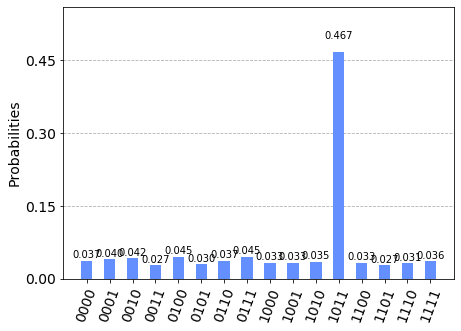

In [210]:
backend = Aer.get_backend('qasm_simulator')
results = execute(circuit, backend, shots = 1024).result()
counts = results.get_counts()
print(counts)
plot_histogram(counts)

In [211]:
### from qiskit.providers.ibmq import least_busy
from qiskit import IBMQ
from qiskit.tools.monitor import job_monitor

provider = IBMQ.load_account()
backend = provider.backends(simulator = False)
qcomp = provider.get_backend('ibmq_5_yorktown')    # ibmqx2
job = execute(circuit, qcomp, optimization_level = 3)
job_monitor(job)

/home/saasha/anaconda3/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


Job Status: job has successfully run


{'0000': 55, '0001': 90, '0010': 36, '0011': 67, '0100': 61, '0101': 89, '0110': 38, '0111': 65, '1000': 57, '1001': 76, '1010': 42, '1011': 74, '1100': 51, '1101': 104, '1110': 46, '1111': 73}


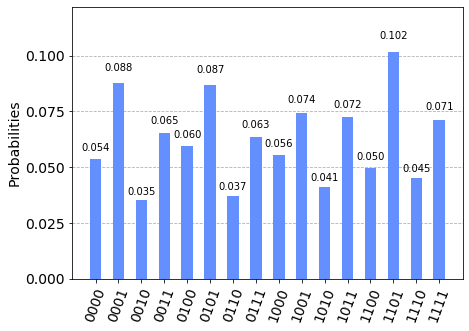

In [212]:
result = job.result()
counts = result.get_counts(circuit)
print(counts)
plot_histogram(counts)

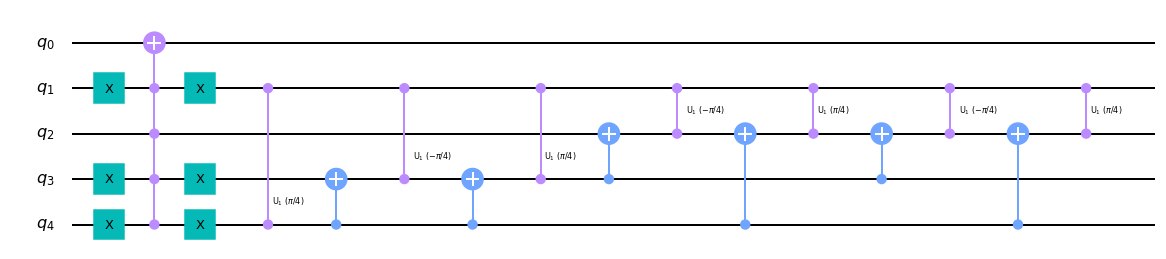